In [16]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, Point, LineString
import numpy as np
import folium
import geopy
import random as rnd
from matplotlib import pyplot as plt
from geopy.geocoders import Yandex, GoogleV3
from shapely.ops import nearest_points
import warnings

warnings.simplefilter(action='ignore')

# Task 1

In [17]:
dolgoprudniy = Point(55.9297243, 37.5199434) 
kremlin = Point(55.752023, 37.6174994)


def get_geodesic_distance(p1, p2):
   lat1 = p1.x
   lon1 = p1.y
   lat2 = p2.x 
   lon2 = p2.y
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)



display(get_geodesic_distance(dolgoprudniy, kremlin))

20.68

# Task 2

In [29]:
big_moscow_districts = gpd.read_file('data/big_moscow_districts.shp')
pl1 = rnd.sample(big_moscow_districts['geometry'].tolist(), 1)[0]
pls = rnd.sample(big_moscow_districts['geometry'].tolist(), 50)

def get_k_nearest_neighbours_by_dist(polygon, polygons, k, kind):
    if k>len(polygons):
        raise NameError('Incorrect K number') 
    if polygon in polygons:
        polygons.remove(polygon)
    df = gpd.GeoDataFrame()
    df["geometry"] = polygons

    if kind == 'by_centroid':
        df["centroid"] = df["geometry"].apply(
            lambda item: get_geodesic_distance(polygon.centroid, item.centroid))   
        return df.sort_values(by="centroid", ignore_index=True).loc[:k-1]
    if kind == 'by_board':
        df["board"] = df["geometry"].apply(
            lambda item: get_geodesic_distance(*nearest_points(polygon, item)))
        return df.sort_values(by="board", ignore_index=True).loc[:k-1]

k_board = get_k_nearest_neighbours_by_dist(pl1, pls, k=8, kind='by_board')
k_centroid = get_k_nearest_neighbours_by_dist(pl1, pls, k=8, kind='by_centroid')
display(k_board)
display(k_centroid)

,geometry,board
0,"POLYGON ((37.84041 55.80369, 37.84051 55.80247...",0.00
1,"POLYGON ((37.73426 55.87864, 37.73551 55.87800...",0.81
2,"POLYGON ((37.80870 55.76024, 37.80866 55.76015...",3.06
3,"POLYGON ((37.84254 55.74718, 37.84265 55.74673...",4.96
4,"POLYGON ((37.71971 55.88591, 37.72021 55.88566...",5.47
5,"POLYGON ((37.75612 55.69137, 37.75606 55.69121...",6.94
6,"POLYGON ((37.68705 55.78185, 37.68654 55.78182...",7.12
7,"POLYGON ((37.73489 55.68743, 37.73449 55.68637...",7.98


,geometry,centroid
0,"POLYGON ((37.84041 55.80369, 37.84051 55.80247...",2.13
1,"POLYGON ((37.80870 55.76024, 37.80866 55.76015...",6.39
2,"POLYGON ((37.73426 55.87864, 37.73551 55.87800...",8.09
3,"POLYGON ((37.84254 55.74718, 37.84265 55.74673...",8.59
4,"POLYGON ((37.75612 55.69137, 37.75606 55.69121...",11.51
5,"POLYGON ((37.83453 55.67789, 37.83470 55.67732...",12.20
6,"POLYGON ((37.71971 55.88591, 37.72021 55.88566...",12.63
7,"POLYGON ((37.68525 55.89508, 37.68891 55.89504...",14.00


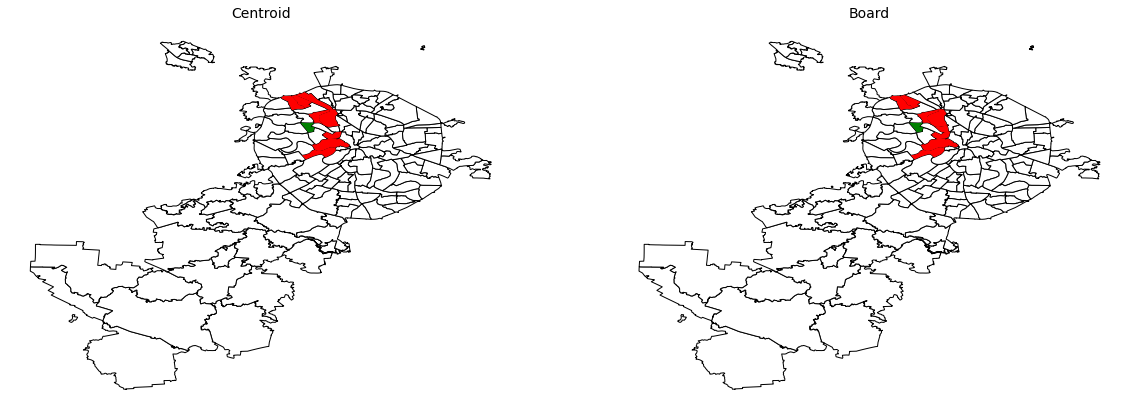

In [19]:

fig = plt.figure(figsize=(20, 10))

ax = plt.subplot(1, 2, 1)
big_moscow_districts.plot(ax=ax, color='white', edgecolor='black')
k_centroid.plot(ax=ax, color='red')
gpd.GeoSeries(pl1).plot(ax=ax, color='green')
plt.title("Centroid", size=14)
ax.set_axis_off()


ax = plt.subplot(1, 2, 2)
big_moscow_districts.plot(ax=ax, color='white', edgecolor='black')
k_board.plot(ax=ax, color='red')
gpd.GeoSeries(pl1).plot(ax=ax, color='green')
plt.title("Board", size=14)
ax.set_axis_off()



# Task 3

In [32]:
def spatial_resample(agg_polygons, init_polygons, 
                                       method='mean', column='random_value', kind='mean'):
    init_polygons['area_initial'] = init_polygons.geometry.area
    batch = gpd.sjoin(agg_polygons, init_polygons, op='intersects')
    batch = batch.reset_index()
    batch['area_of_intersection'] = [
        batch.iloc[i]['geometry'].intersection(
            init_polygons.iloc[batch.iloc[i]['index_right']]['geometry']).area for i in batch.index]
    if kind == 'mean':
        batch[column] = batch[column] * batch['area_of_intersection'] / (
            batch['area_initial'])
    if kind == 'max':
        batch['area_of_intersection_max'] = batch.groupby(
            ['index_right'])['area_of_intersection'].transform(lambda x: max(x))
        batch[column] = (batch.apply(
            lambda x: x[column] if x.area_of_intersection == x.area_of_intersection_max else 0, axis=1))
    if kind != 'mean' and kind != 'max':
        raise NameError("Unknown kind")
  
    batch['RIND'] = batch.index
    batch = batch[['RIND', 'geometry', column]].dissolve(by=batch['RIND'], aggfunc=method, 
                                                       sort=False)
    return batch

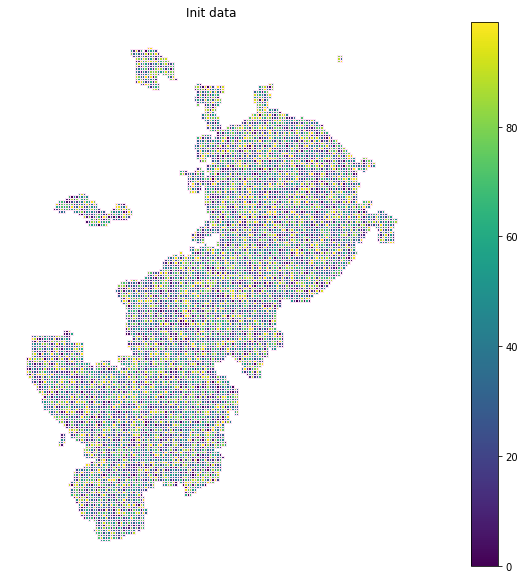

In [21]:
grid_big_moscow = gpd.read_file('data/grid_big_moscow.shp')
grid_big_moscow.crs = "EPSG:4326"  
grid_big_moscow['random_value'] = np.random.randint(0, 100, len(grid_big_moscow))

fig = plt.figure(figsize=(20, 10))
plt.title('Init data', fontsize=12)
ax = plt.gca()
grid_big_moscow.plot(ax=ax, column='random_value', cmap='viridis', edgecolor='#ffe6f8', legend=True)
ax.set_axis_off()

# Task 4

## Task4.1

In [22]:
display(k_board)

,geometry,board
0,"POLYGON ((37.56054 55.84484, 37.55877 55.84410...",0.00
1,"POLYGON ((37.58473 55.80868, 37.58434 55.80869...",1.50
2,"POLYGON ((37.58863 55.79206, 37.58849 55.79167...",2.58
3,"POLYGON ((37.60967 55.75829, 37.60967 55.75827...",2.98
4,"POLYGON ((37.43648 55.87958, 37.43749 55.87989...",3.09
5,"POLYGON ((37.58653 55.79344, 37.58539 55.79287...",3.13
6,"POLYGON ((37.46472 55.88346, 37.46732 55.88379...",3.31
7,"POLYGON ((37.57445 55.74633, 37.57413 55.74545...",4.12


In [39]:
m = folium.Map(location=[55.755826, 37.6172999])

by_centroid = folium.Choropleth(
    geo_data=k_centroid[["geometry", "centroid"]].to_json(),
    data=pd.DataFrame({"ID": k_centroid.index,
              "Distance_by_centroid": k_centroid["centroid"]}),
    columns=["ID", "Distance_by_centroid"],
    key_on="feature.id",
    fill_color="YlGn",
    nan_fill_color="red",
    name="10 nearest by centroid").add_to(m)
folium.GeoJsonTooltip(
fields=["centroid"]).add_to(by_centroid.geojson)

by_board = folium.Choropleth(
    geo_data=k_board[["geometry", "board"]].to_json(),
    data=pd.DataFrame({"ID": k_board.index,
              "Distance_by_board": k_board["board"]}),
    columns=["ID", "Distance_by_board"],
    key_on="feature.id",
    fill_color="YlGn",
    nan_fill_color="red",
    name="10 nearest by board").add_to(m)
folium.GeoJsonTooltip(
fields=["board"]).add_to(by_board.geojson)

folium.Choropleth(
    geo_data=gpd.GeoDataFrame({'geometry': pls}).to_json(),
    data=pd.DataFrame({"ID": k_centroid.index,
              "Distance_by_centroid": np.nan}),
    columns=["ID", "Distance_by_centroid"],
    key_on="feature.id",
    fill_color="BuPu",
    nan_fill_color="yellow",
    nan_fill_opacity=0.2,
    name="Base polygons").add_to(m)

m.choropleth(pl1, fill_color='#dbeb34', name='Target polygon', fill_opacity=1)

folium.LayerControl().add_to(m)
m

## Task 4.2

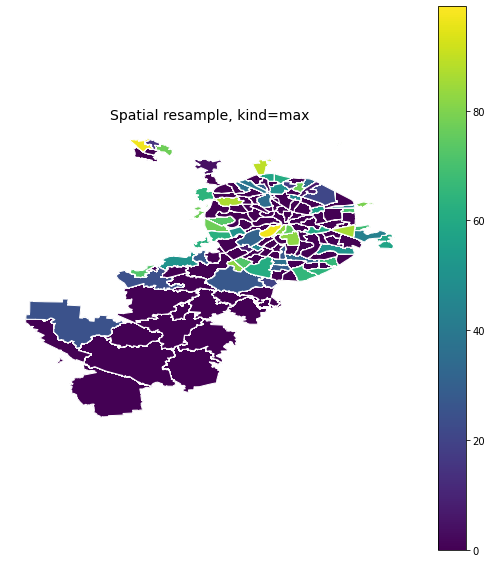

In [24]:
resample_mean_max = spatial_resample(agg_polygons=big_moscow_districts, init_polygons=grid_big_moscow, 
                                       method='mean', column='random_value', kind='max')
fig = plt.figure(figsize=(20, 10))

ax = plt.subplot(1, 2, 2)
plt.title('Spatial resample, kind=max', fontsize=14)
resample_mean_max.plot(ax=ax, column='random_value', cmap='viridis', edgecolor='white', legend=True)
ax.set_axis_off()

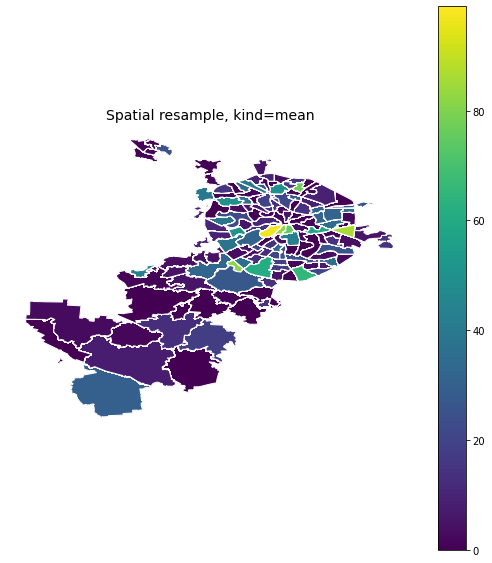

In [25]:
resample_mean_mean = spatial_resample(agg_polygons=big_moscow_districts, init_polygons=grid_big_moscow, 
                                       method='mean', column='random_value', kind='mean')
fig = plt.figure(figsize=(20, 10))

ax = plt.subplot(1, 2, 2)
plt.title('Spatial resample, kind=mean', fontsize=14)
resample_mean_mean.plot(ax=ax, column='random_value', cmap='viridis', edgecolor='white', legend=True)
ax.set_axis_off()